# Domain-area Tests

## Symmetries are simple tests

One of the simplest domain-area tests we can perform is to check that expected symmetry relationships actually hold. For instance, lets look at a square box containing fluid particles with an initial velocity along one of the diagonal directions (one experimental realization would be a box of fluid in free fall hitting the floor right on one of its corners). We expect that the fluid will slosh around the box, respecting a symmetry axis along that same diagonal. More to the point, we expect that (scalar) physical quantities $q(x, y)$ will map to $q(y, x)$.

The following sets up this problem:

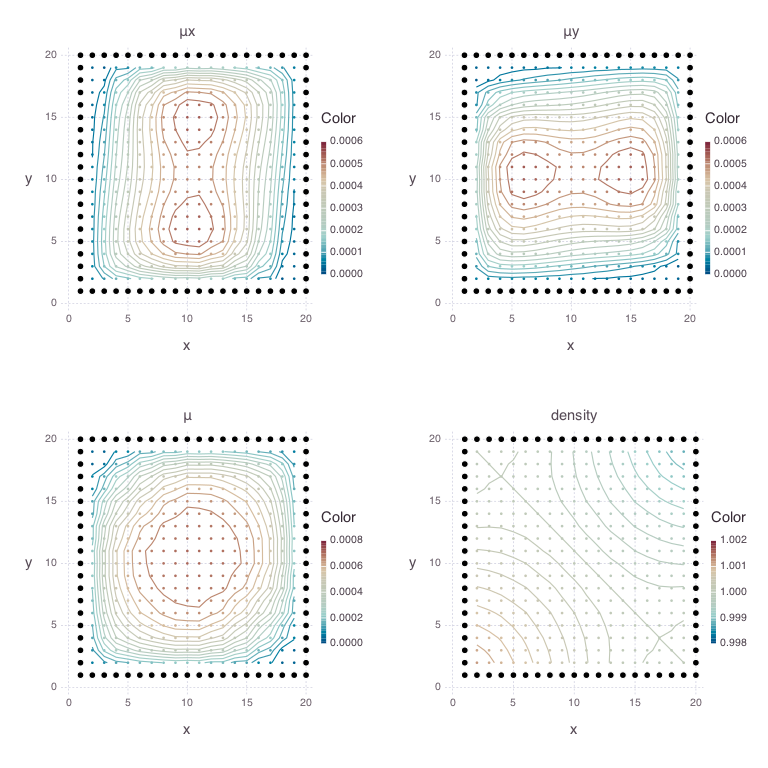

In [1]:
using LatBo
using Gadfly
# Plotting helper functions
include(joinpath(Pkg.dir("LatBo"), "extras", "SimplePlot.jl"))

# Sets up a square box with initial velocity μ₀
Npoints, δt, δx = (20, 20), 5e-4, 1e-3
sim = lbgk(:D2Q9, Npoints, δt, δx; viscosity=4e-1, μ₀ = 1e-2/√3.0 * δt/δx * [1, 1])
sim.playground[:] = Playground.SOLID
sim.playground[2:(end-1), 2:(end-1)] = Playground.FLUID

# Then computes flow for a number of steps
run!(sim, nsteps=60)

# Finally, plots momenum :mu, and :density, using helper function from LatBo
set_default_plot_size(8inch, 8inch * float(Npoints[2])/float(Npoints[1]))

theme = Theme(default_point_size=1pt, highlight_width=0pt)
vstack(
  hstack(plot(:μx, sim, theme), plot(:μy, sim, theme)),
  hstack(plot(:μ, sim, theme), plot(:density, sim, theme))
)

We see above the momentum along x and y, as well as the total momentum. The symmetries are fairly clear in the pictures. But we want to actually test them numerically. This brings in issues of accuracy and how to test floating point numbers. However, symmetries are often respected up to numerical precision. Indeed, this is exactly what we are testing for. Either there is a compelling reason an algorithm breaks a symmetry - and it is a known "feature" of the algorithm from the outset - or the symmetry should emerge from the algorithm naturally.

In [5]:
using FactCheck: facts, @fact, roughly, context, not
facts("Fluid with [1, 1] velocity in closed square box: symmetry analysis") do
    context("density: ρ(x, y) ↦ ρ(y, x)") do
        ρ = density(sim)
        @fact ρ => roughly(transpose(ρ), 1e-16)
    end
    context("momentum") do
        μ = momentum(sim)
        μₓ, μy = squeeze(μ[1, :, :], 1), squeeze(μ[2, :, :], 1)       
        context("magnitude: |μ(x, y)| ↦ |μ(y, x)|") do
            magnitude = √(μₓ^2 + μy^2)
            @fact magnitude => roughly(transpose(magnitude), 1e-16)
        end
        context("vectorial: μₓ(x, y) ↦ μy(y, x)") do
            @fact μₓ => roughly(transpose(μy), 1e-16)
        end
        context("negative tests to check relationships that best not be") do
            @fact μₓ => not(roughly(μy))
            @fact μₓ => not(roughly(transpose(μₓ)))
        end
    end
end
nothing

Fluid with [1, 1] velocity in closed square box: symmetry analysis
     - density: ρ(x, y) ↦ ρ(y, x)
     - momentum
       - magnitude: |μ(x, y)| ↦ |μ(y, x)|
       - vectorial: μₓ(x, y) ↦ μy(y, x)
       - negative tests checks relationships that best not be
5 facts verified.


There are two simple ingredients here. First, we specifically setup the simulation with an input displaying a given symmetry. Then, we tested that the output recovers the same symmetry, despite that it is nowhere hard-coded into the algorithm. We were careful to choose an example where the symmetry is respected by the algorithm; if we rotate the box by 30 degrees while keeping the orientation of the discrete LB grid constant, then the LB algorithm (and the boundary conditions) break the symmetry we are looking for. The checks would have to take into account the degree of convergence with respect to the discrete grid, something quite a bit more challenging to setup. In the example above, we also setup some negative tests to try and avoid false positives (e.g. momentum is zero everywhere).

This test is not sufficient in itself; it could be that the momentum respect the symmetry of the input, but is orders of magnitude off. Nor would this test yield an easy diagnostic were something to go wrong. However, it does show that all the right bits are interacting (mostly) in all the right ways.

## Flow in a pipe

Domain-area 101 is generally where we want to look next for inspiration. In the case of fluid dynamics, that would likely be the Couette flow, or flow between parallel plates. It is standard enough to warrant its own [wikipedia page](http://en.wikipedia.org/wiki/Couette_flow). The setup is very simple; two plates parallel to the flow, an inlet and an outlet perpendicular to it:

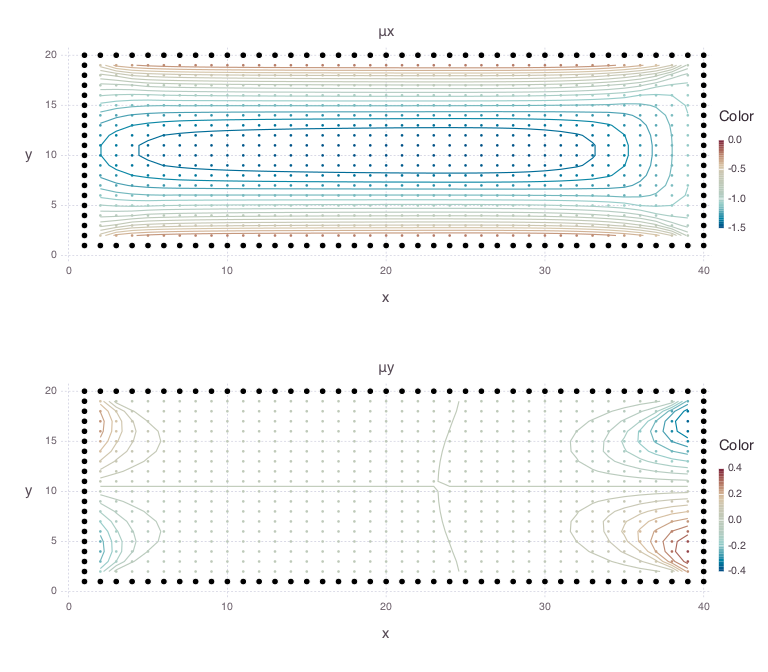

In [38]:
Npoints = 40, 20
sim = lbgk(:D2Q9, Npoints, δt, δx; viscosity=4e-1, Δp=0.2, μ₀=0/√3.0 * δt/δx *[1, 0])
sim.playground[:] = Playground.SOLID
sim.playground[2:(end-1), 2:(end-1)] = Playground.FLUID
sim.playground[1, :] = Playground.INLET
sim.playground[end, :] = Playground.OUTLET

# Then computes flow for a number of steps
run!(sim, nsteps=500)

# Finally, plots momentum :mu, and :density, using helper function from LatBo
set_default_plot_size(8inch, 7inch)

theme = Theme(default_point_size=1pt, highlight_width=0pt)
vstack(plot(:μx, sim, theme), plot(:μy, sim, theme))

The fluid should be strictly parallel to the plates ($\mu_y=0$), with a parabolic velocity profile $\mu_x \backsim \frac{\Delta P}{\nu} (y^2-h^2)$, where $\Delta P$ is the pressure gradient and $\nu$ the viscosity. The velocity profile at the inlet and at the outlet are inputs. In the case of the simulation setup here, both profiles are actually flat. We choose to do so to check that the expected profile appears of itself when sufficiently far from either end. The cost, however, is that the region between the two plates must be sufficiently long, and the simulation run long enough for the expected flow to establish itself. What all this implies is that we will have to be careful to converge results sufficiently.

What we want to do here is check that the relationships given above do hold:
- the profile is proportional to the difference in pressure between inlet and outlet
- the profile is parabolic with respect to y, maximum at the center, and (near) zero near the plates

The first item will require simulating the flow at least twice. As mentioned previously, these domain-area tests can be quite time-consuming, at least with respect to the mechanical/unit-tests presented earlier. 

In [39]:
using FactCheck: @fact, facts, roughly, context
facts("Couette flow") do
    context("Velocity profile is parabolic") do
        
    end
end

Dict{Uint8,LocalKernel} with 1 entry:
  0x02 => FluidKernel(SingleRelaxationTime{Float64}(0.625),[0x04=>NashZeroOrder…